# Prediction

## Load preprocessed dataframes

In [2]:
from utils import *

train_df = pd.read_pickle("../out/train.pkl")
test_df = pd.read_pickle("../out/test.pkl")

## Columns to drop and feature target

In [3]:
columns_to_drop = ["loan_id", "status"]
target_column = "status"

train_df.drop(columns_to_drop, axis=1).head()

,loan_amount,payments,issuance_frequency_per_month,no. of municipalities with inhabitants < 499,no. of cities,balance_mean,balance_min,client_count_mean,operation_count,type_transaction_count_withdrawal,num_times_under_zero,account_age,days_since_last_transaction
0,80952,3373,1.000000,0,1,32590.624074,1100.0,2.0,44,32,False,313,5
1,30276,2523,1.000000,87,7,25197.092500,715.0,1.0,56,34,False,388,19
2,165960,6915,1.000000,74,8,52523.244800,700.0,1.0,107,88,False,561,2
3,88440,7370,13.044643,9,8,62778.090323,200.0,2.0,25,15,False,179,6
4,104808,8734,1.000000,151,5,38709.830000,500.0,2.0,25,18,False,186,6


## Tune Models

### Decision Tree

In [4]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 7)
}

dt, dt_fs, dt_os, dt_fs_os = (tune_model(
    train_df, 
    DecisionTreeClassifier(),
    parameter_grid, 
    columns_to_drop, 
    target_column,
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8484690893901419
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__splitter': 'random'}
Best score: 0.8579490392648287
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__splitter': 'random'}
Best score: 0.8489689501531608
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__splitter': 'random'}
Best score: 0.8195996936786412
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__splitter': 'random'}


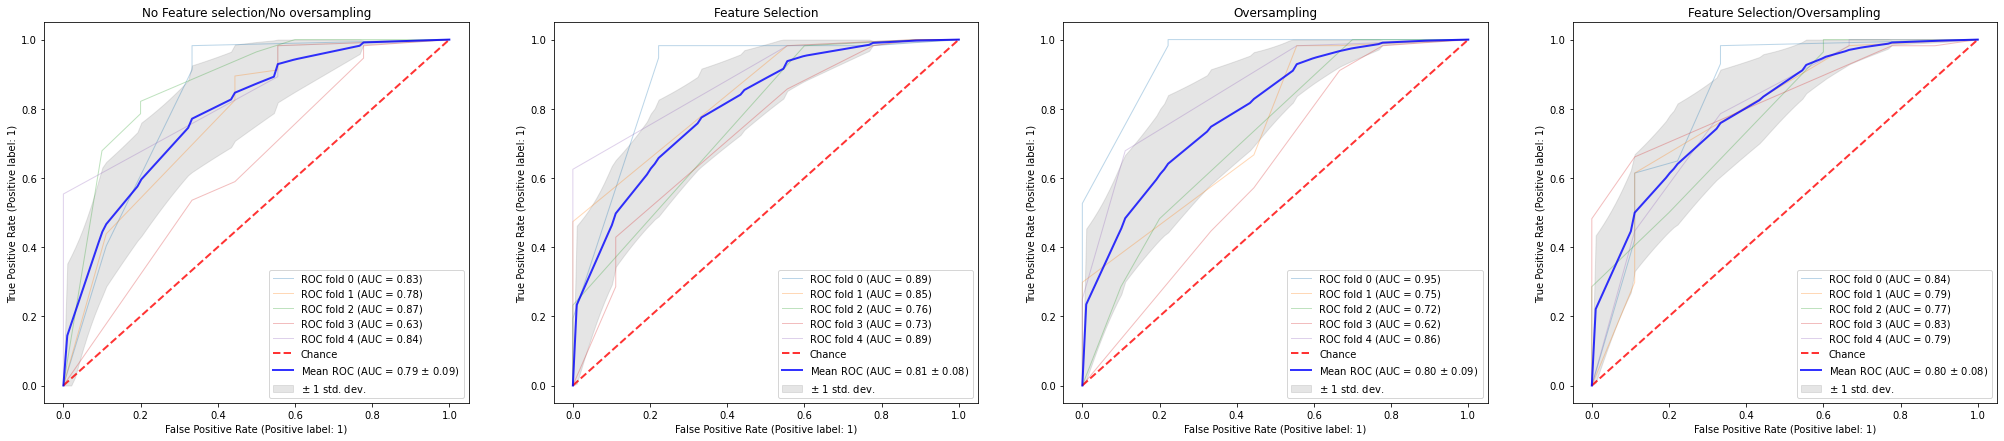

In [5]:
plotROC([dt, dt_fs, dt_os, dt_fs_os], train_df, columns_to_drop, target_column, scaler=None)

### SVM
Needs to be scaled (StandardScaler)

In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

parameter_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc, svc_fs, svc_os, svc_fs_os = (tune_model(
    train_df, 
    SVC(probability=True), 
    parameter_grid,
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True, True)))

Best score: 0.8704218880534669
Best parameters: {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'linear'}
Best score: 0.8596282372598163
Best parameters: {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'linear'}
Best score: 0.8748308270676691
Best parameters: {'model__C': 50, 'model__gamma': 0.0001, 'model__kernel': 'sigmoid'}
Best score: 0.8743386243386244
Best parameters: {'model__C': 50, 'model__gamma': 0.0001, 'model__kernel': 'sigmoid'}


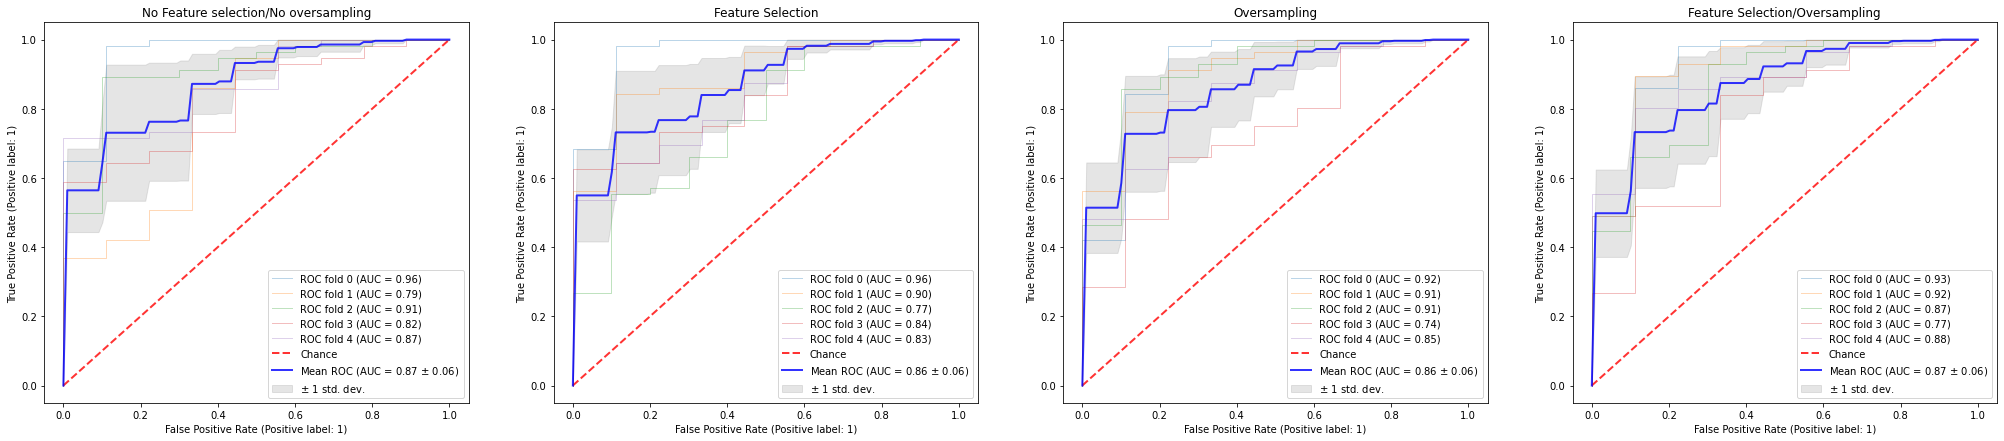

In [7]:
plotROC([svc, svc_fs, svc_os, svc_fs_os], train_df, columns_to_drop, target_column, scaler=StandardScaler())

###  K-nearest neighbours (KNN)
Just like the SVM model, the KNN model also requires the data to be scaled.

In [8]:
from sklearn import neighbors

parameter_grid = {
    'n_neighbors': [4, 5, 6, 7, 10, 15],
    'leaf_size': [5, 10, 15, 20, 50, 100],
    'n_jobs': [-1],
    'algorithm': ['auto']
}

knn, knn_fs, knn_os, knn_fs_os = (tune_model(
    train_df, 
    neighbors.KNeighborsClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8471539961013645
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 4}
Best score: 0.8567700501253134
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 4}
Best score: 0.863089320523531
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 10, 'model__n_jobs': -1, 'model__n_neighbors': 15}
Best score: 0.8738499025341131
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 50, 'model__n_jobs': -1, 'model__n_neighbors': 4}


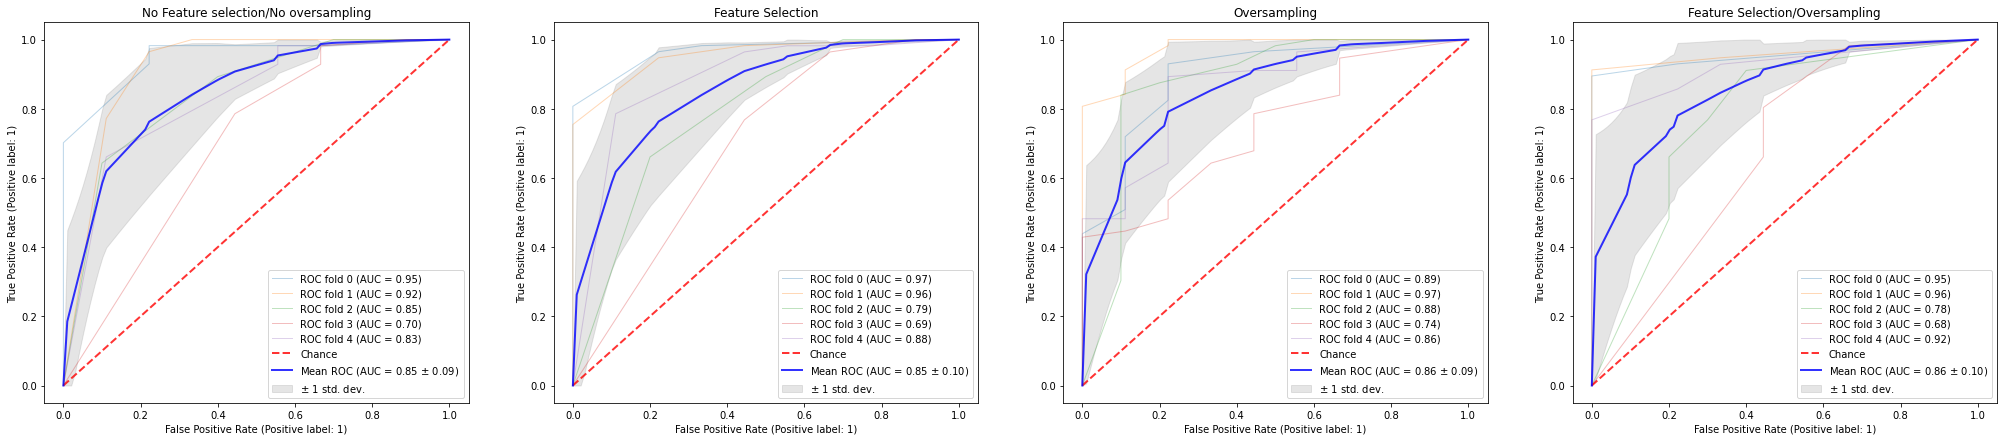

In [9]:
plotROC([knn, knn_fs, knn_os, knn_fs_os], train_df, columns_to_drop, target_column, scaler=StandardScaler())

### Naïve Bayes

In [10]:
from sklearn.naive_bayes import GaussianNB

parameter_grid = {}

nb, nb_fs, nb_os, nb_fs_os = (tune_model(
    train_df, 
    GaussianNB(),
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8759210526315788
Best parameters: {}
Best score: 0.861079782790309
Best parameters: {}
Best score: 0.8643713450292397
Best parameters: {}
Best score: 0.8585867446393763
Best parameters: {}


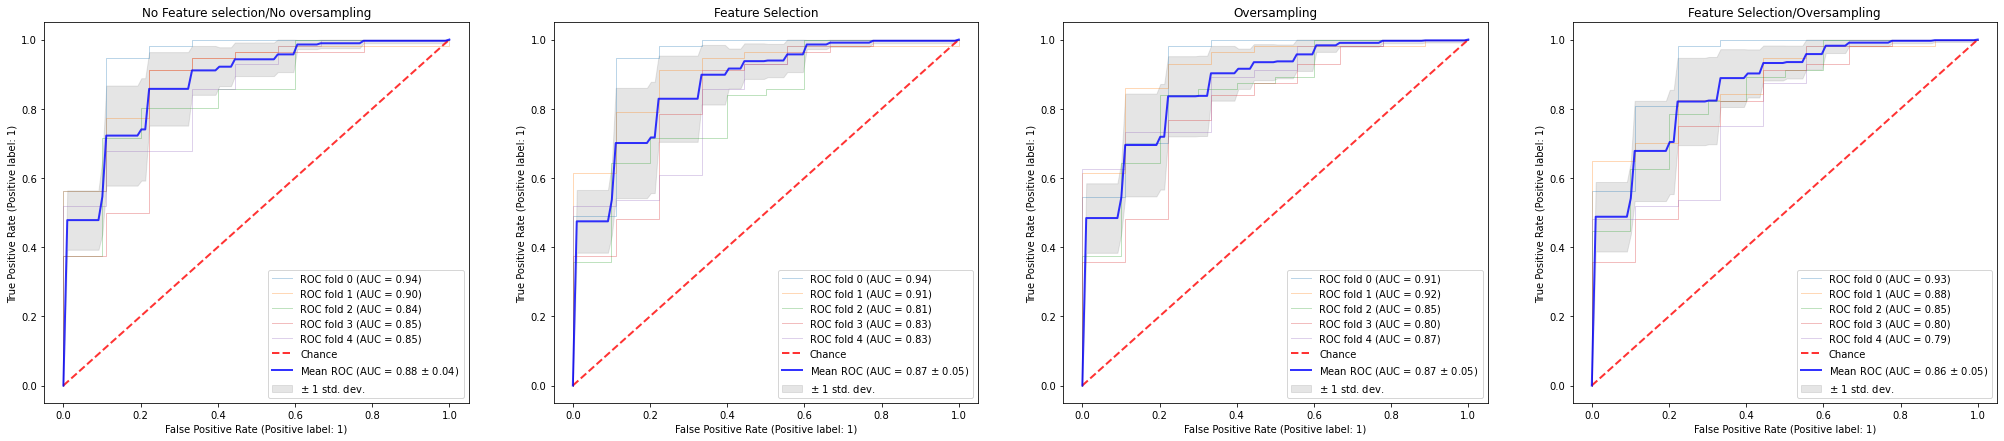

In [11]:
plotROC([nb, nb_fs, nb_os, nb_fs_os], train_df, columns_to_drop, target_column, scaler=StandardScaler())

### Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
}

rfc, rfc_fs, rfc_os, rfc_fs_os = (tune_model(
    train_df, 
    RandomForestClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column,
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8897786131996657
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__n_estimators': 200, 'model__n_jobs': -1}
Best score: 0.8757915622389307
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 15, 'model__n_estimators': 100, 'model__n_jobs': -1}
Best score: 0.8878790726817043
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 15, 'model__n_estimators': 200, 'model__n_jobs': -1}
Best score: 0.8796101364522417
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 15, 'model__n_estimators': 50, 'model__n_jobs': -1}


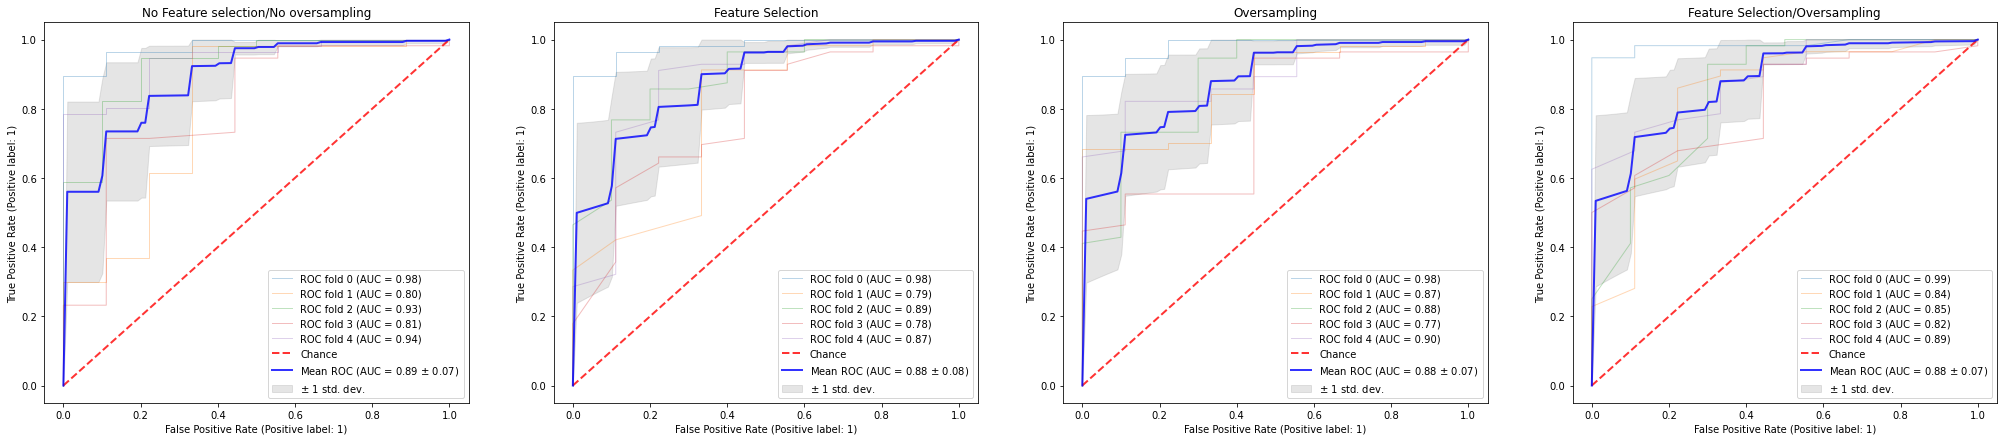

In [13]:
plotROC([rfc, rfc_fs, rfc_os, rfc_fs_os], train_df, columns_to_drop, target_column, scaler=None)

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

parameter_grid = {
    "max_iter": [1000, 5000, 10000],
    "solver": ["lbfgs"]
}

lr, lr_fs, lr_os, lr_fs_os = (tune_model(
    train_df,
    LogisticRegression(),
    parameter_grid,
    columns_to_drop,
    target_column,
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8705005569479255
Best parameters: {'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Best score: 0.8756203007518797
Best parameters: {'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Best score: 0.8657337788916737
Best parameters: {'model__max_iter': 10000, 'model__solver': 'lbfgs'}
Best score: 0.8791402116402116
Best parameters: {'model__max_iter': 1000, 'model__solver': 'lbfgs'}


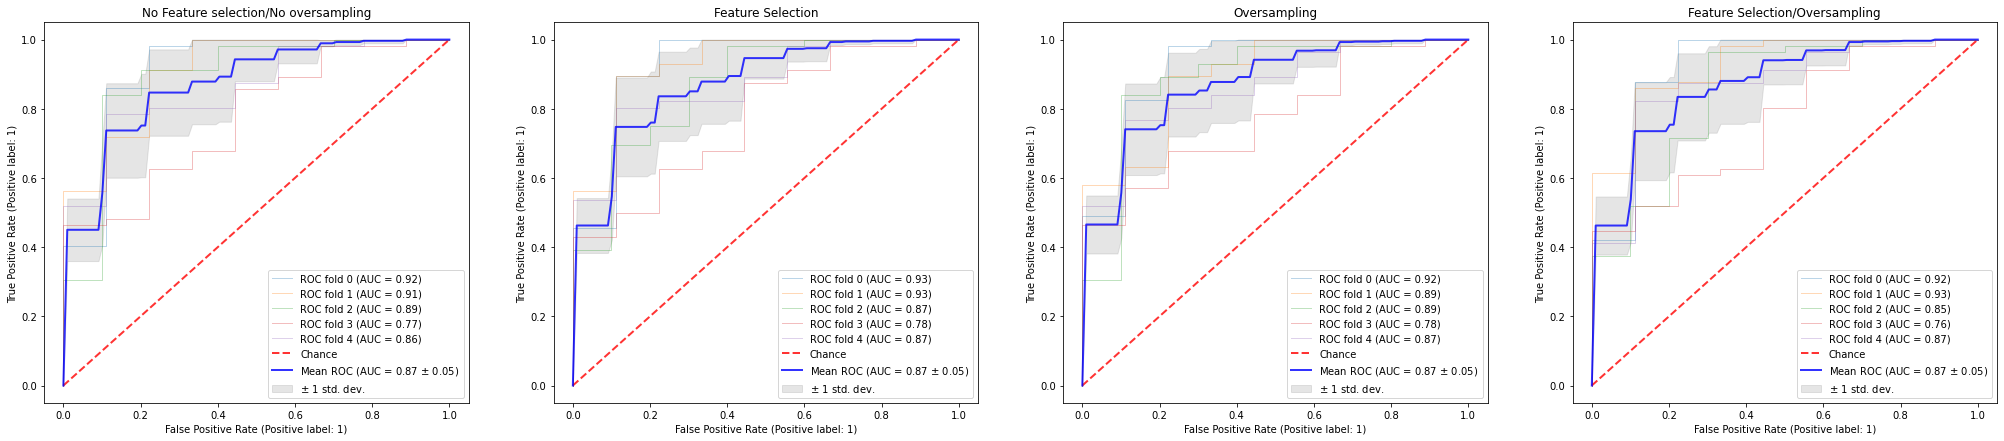

In [15]:
plotROC([lr, lr_fs, lr_os, lr_fs_os], train_df, columns_to_drop, target_column, scaler=StandardScaler())

## Comparing Models

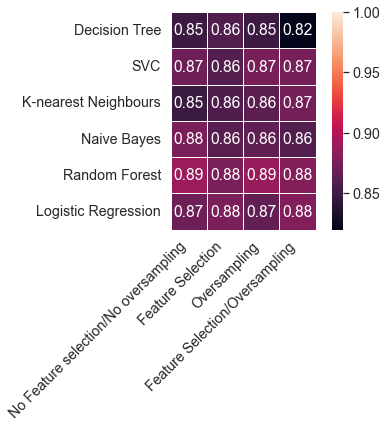

In [88]:
import seaborn as sb

scores = {
    "Decision Tree": [dt, dt_fs, dt_os, dt_fs_os],
    "SVC": [svc, svc_fs, svc_os, svc_fs_os],
    "K-nearest Neighbours": [knn, knn_fs, knn_os, knn_fs_os],
    "Naive Bayes": [nb, nb_fs, nb_os, nb_fs_os],
    "Random Forest": [rfc, rfc_fs, rfc_os, rfc_fs_os],
    "Logistic Regression": [lr, lr_fs, lr_os, lr_fs_os]
}

x_axis_labels = ["No Feature selection/No oversampling", "Feature Selection", "Oversampling", "Feature Selection/Oversampling"]
y_axis_labels = scores.keys()

plt.figure(figsize=(10, 8))

scores_array = np.array([[model.best_score_ for model in models] for models in scores.values()])

sb.set(font_scale=1.3)
sb.heatmap(uniform_data, annot=True, linewidths=0.5, vmax=1, square=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

plt.xticks(rotation=45, horizontalalignment='right');

## Save results

In [ ]:
X_result = test_df.drop(columns_to_drop, axis=1)

y_result = dt.predict_proba(X_result)[:, 0]

result = pd.DataFrame({"Id": test_df["loan_id"], "Predicted": y_result})
result.drop_duplicates(inplace=True)
result.to_csv("../out/result.csv", index=False)